#Electricity demand projection up to 2050 from a 2018–2027 CSV file.
This file is to generate CSV with load forecast for the different scenarios


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import all dirs
parent_dir = Path(os.getcwd()).parents[0]
sys.path.append(str(parent_dir))
from src.paths import all_dirs
dirs = all_dirs()
dirs.keys()

dict_keys(['', 'config', 'data', 'literature', 'notebooks', 'results', 'src', 'data/processed', 'data/raw', 'data/processed/scaled_loads', 'data/raw/cutouts', 'data/raw/demand', 'data/raw/networks', 'results/graphs'])

In [ ]:
"""
Electricity demand projection up to 2050 for all scenarios (tendencial, caso_base, matriz_productiva)
based on 2018–2027 historical data.
"""

# ---------------------------
# SETTINGS
# ---------------------------
path = dirs["data/raw/demand"]
csv_file = "demand_ec_2018_2027.csv"  # input file (2018–2027)
csv_path_hist = os.path.join(path, csv_file)
scenarios = ["trend", "base", "productive_mix"]  # base scenarios to project
year_projection_end = 2050
calibration_window = (2022, 2027)  # used for slope and CAGR
output_dir = dirs["data/processed"]


# ---------------------------
# FUNCTIONS
# ---------------------------
def load_historical(csv_path: str) -> pd.DataFrame:
    """Load and interpolate the historical data (2018–2027)."""
    df = pd.read_csv(csv_path)
    if "year" not in df.columns:
        raise ValueError("CSV must contain a 'year' column.")
    df = df.set_index("year").sort_index()
    years = pd.Index(range(int(df.index.min()), int(df.index.max()) + 1), name="year")
    df = df.reindex(years).interpolate().round(3)
    return df


def calc_slope(df: pd.DataFrame, col: str, y1: int, y2: int) -> float:
    """Linear slope (GWh/year)."""
    return (float(df.loc[y2, col]) - float(df.loc[y1, col])) / (y2 - y1)


def calc_cagr(df: pd.DataFrame, col: str, y1: int, y2: int) -> float:
    """Compound annual growth rate (CAGR)."""
    v1, v2 = float(df.loc[y1, col]), float(df.loc[y2, col])
    if v1 <= 0:
        raise ValueError(f"CAGR invalid: {col} value in {y1} <= 0.")
    return (v2 / v1) ** (1 / (y2 - y1)) - 1


def project_linear(
    base_value: float, slope: float, years: list[int], base_year: int
) -> np.ndarray:
    """Linear projection: v = v_base + slope*(year - base_year)."""
    return np.array([base_value + slope * (y - base_year) for y in years], dtype=float)


def project_exponential(
    base_value: float, cagr: float, years: list[int], base_year: int
) -> np.ndarray:
    """Exponential projection: v = v_base * (1 + cagr)^(year - base_year)."""
    return np.array(
        [base_value * ((1 + cagr) ** (y - base_year)) for y in years], dtype=float
    )


def avg_growth(vals: np.ndarray) -> float:
    """Average year-to-year increment."""
    diffs = np.diff(vals)
    return float(np.mean(diffs))


# ---------------------------
# MAIN PIPELINE
# ---------------------------
hist = load_historical(csv_path_hist)
y1, y2 = calibration_window
hist_end_year = int(hist.index.max())
proj_years = list(range(hist_end_year + 1, year_projection_end + 1))
results_df = {}

for base_scenario in scenarios:
    if base_scenario not in hist.columns:
        print(
            f"[WARN] Scenario '{base_scenario}' not found in historical data, skipping."
        )
        continue

    # Compute slope and CAGR
    slope = calc_slope(hist, base_scenario, y1, y2)
    cagr = calc_cagr(hist, base_scenario, y1, y2)
    v_base = float(hist.loc[hist_end_year, base_scenario])

    # Compute projections
    proj_lin = project_linear(v_base, slope, proj_years, base_year=hist_end_year)
    proj_exp = project_exponential(v_base, cagr, proj_years, base_year=hist_end_year)

    # Build projection DataFrame
    proj_df = pd.DataFrame(
        {
            "proj_linear_gwh": np.round(proj_lin, 3),
            "proj_exponential_gwh": np.round(proj_exp, 3),
        },
        index=pd.Index(proj_years, name="year"),
    )

    # Combine with historical data
    out = hist.copy()
    out[f"{base_scenario}_proj_linear_gwh"] = np.nan
    out[f"{base_scenario}_proj_exponential_gwh"] = np.nan
    out = pd.concat([out, proj_df], axis=0)
    out.loc[proj_years, f"{base_scenario}_proj_linear_gwh"] = proj_df[
        "proj_linear_gwh"
    ].values
    out.loc[proj_years, f"{base_scenario}_proj_exponential_gwh"] = proj_df[
        "proj_exponential_gwh"
    ].values
    out.drop(
        columns=[
            f"{base_scenario}_proj_linear_gwh",
            f"{base_scenario}_proj_exponential_gwh",
        ],
        inplace=True,
    )
    for scenario in scenarios:
        if scenario != base_scenario:
            out.drop(columns=[scenario], inplace=True)
    # locate the last year of projection
    out.at[hist_end_year, "proj_exponential_gwh"] = out.at[hist_end_year, base_scenario]
    out.at[hist_end_year, "proj_linear_gwh"] = out.at[hist_end_year, base_scenario]
    val = out.at[hist_end_year, base_scenario]
    proj_df = pd.concat(
        [
            pd.DataFrame(
                {"proj_linear_gwh": [val], "proj_exponential_gwh": [val]},
                index=[2017],
            ),
            proj_df,
        ]
    )
    # Save CSV
    output_path = os.path.join(
        dirs["data/processed"], f"demand_projection_2018_2050_{base_scenario}.csv"
    )
    out.reset_index().to_csv(output_path, index=False)
    print(f"[OK] Saved: {output_path}")
    # Summary info
    print(f"\n=== {base_scenario.upper()} ===")
    print(f"Calibration window: {y1}–{y2}")
    print(f"Linear slope ≈ {slope:.3f} GWh/year")
    print(f"CAGR ≈ {100*cagr:.3f}% per year")
    print(f"Base value ({hist_end_year}): {v_base:.2f} GWh")
    print(f"Avg annual growth (linear): {avg_growth(proj_lin):.2f} GWh/year")
    print(
        f"First-year growth: linear {proj_lin[1]-proj_lin[0]:.2f}, exp {proj_exp[1]-proj_exp[0]:.2f} GWh"
    )

    results_df[base_scenario] = proj_df



[OK] Saved: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\demand_projection_2018_2050_trend.csv

=== TREND ===
Calibration window: 2022–2027
Linear slope ≈ 1.600 GWh/year
CAGR ≈ 5.073% per year
Base value (2027): 36.50 GWh
Avg annual growth (linear): 1.60 GWh/year
First-year growth: linear 1.60, exp 1.95 GWh
[OK] Saved: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\demand_projection_2018_2050_base.csv

=== BASE ===
Calibration window: 2022–2027
Linear slope ≈ 1.900 GWh/year
CAGR ≈ 5.051% per year
Base value (2027): 43.50 GWh
Avg annual growth (linear): 1.90 GWh/year
First-year growth: linear 1.90, exp 2.31 GWh
[OK] Saved: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\demand_projection_2018_2050_productive_mix.csv

=== PRODUCTIVE_MIX ===
Calibration window: 2022–2027
Linear slope ≈ 4.200 GWh/year
CAGR ≈ 9.975% per year
Base value (2027): 55.50 GWh
Avg annual growth (linear): 4.20 GWh/year
First-

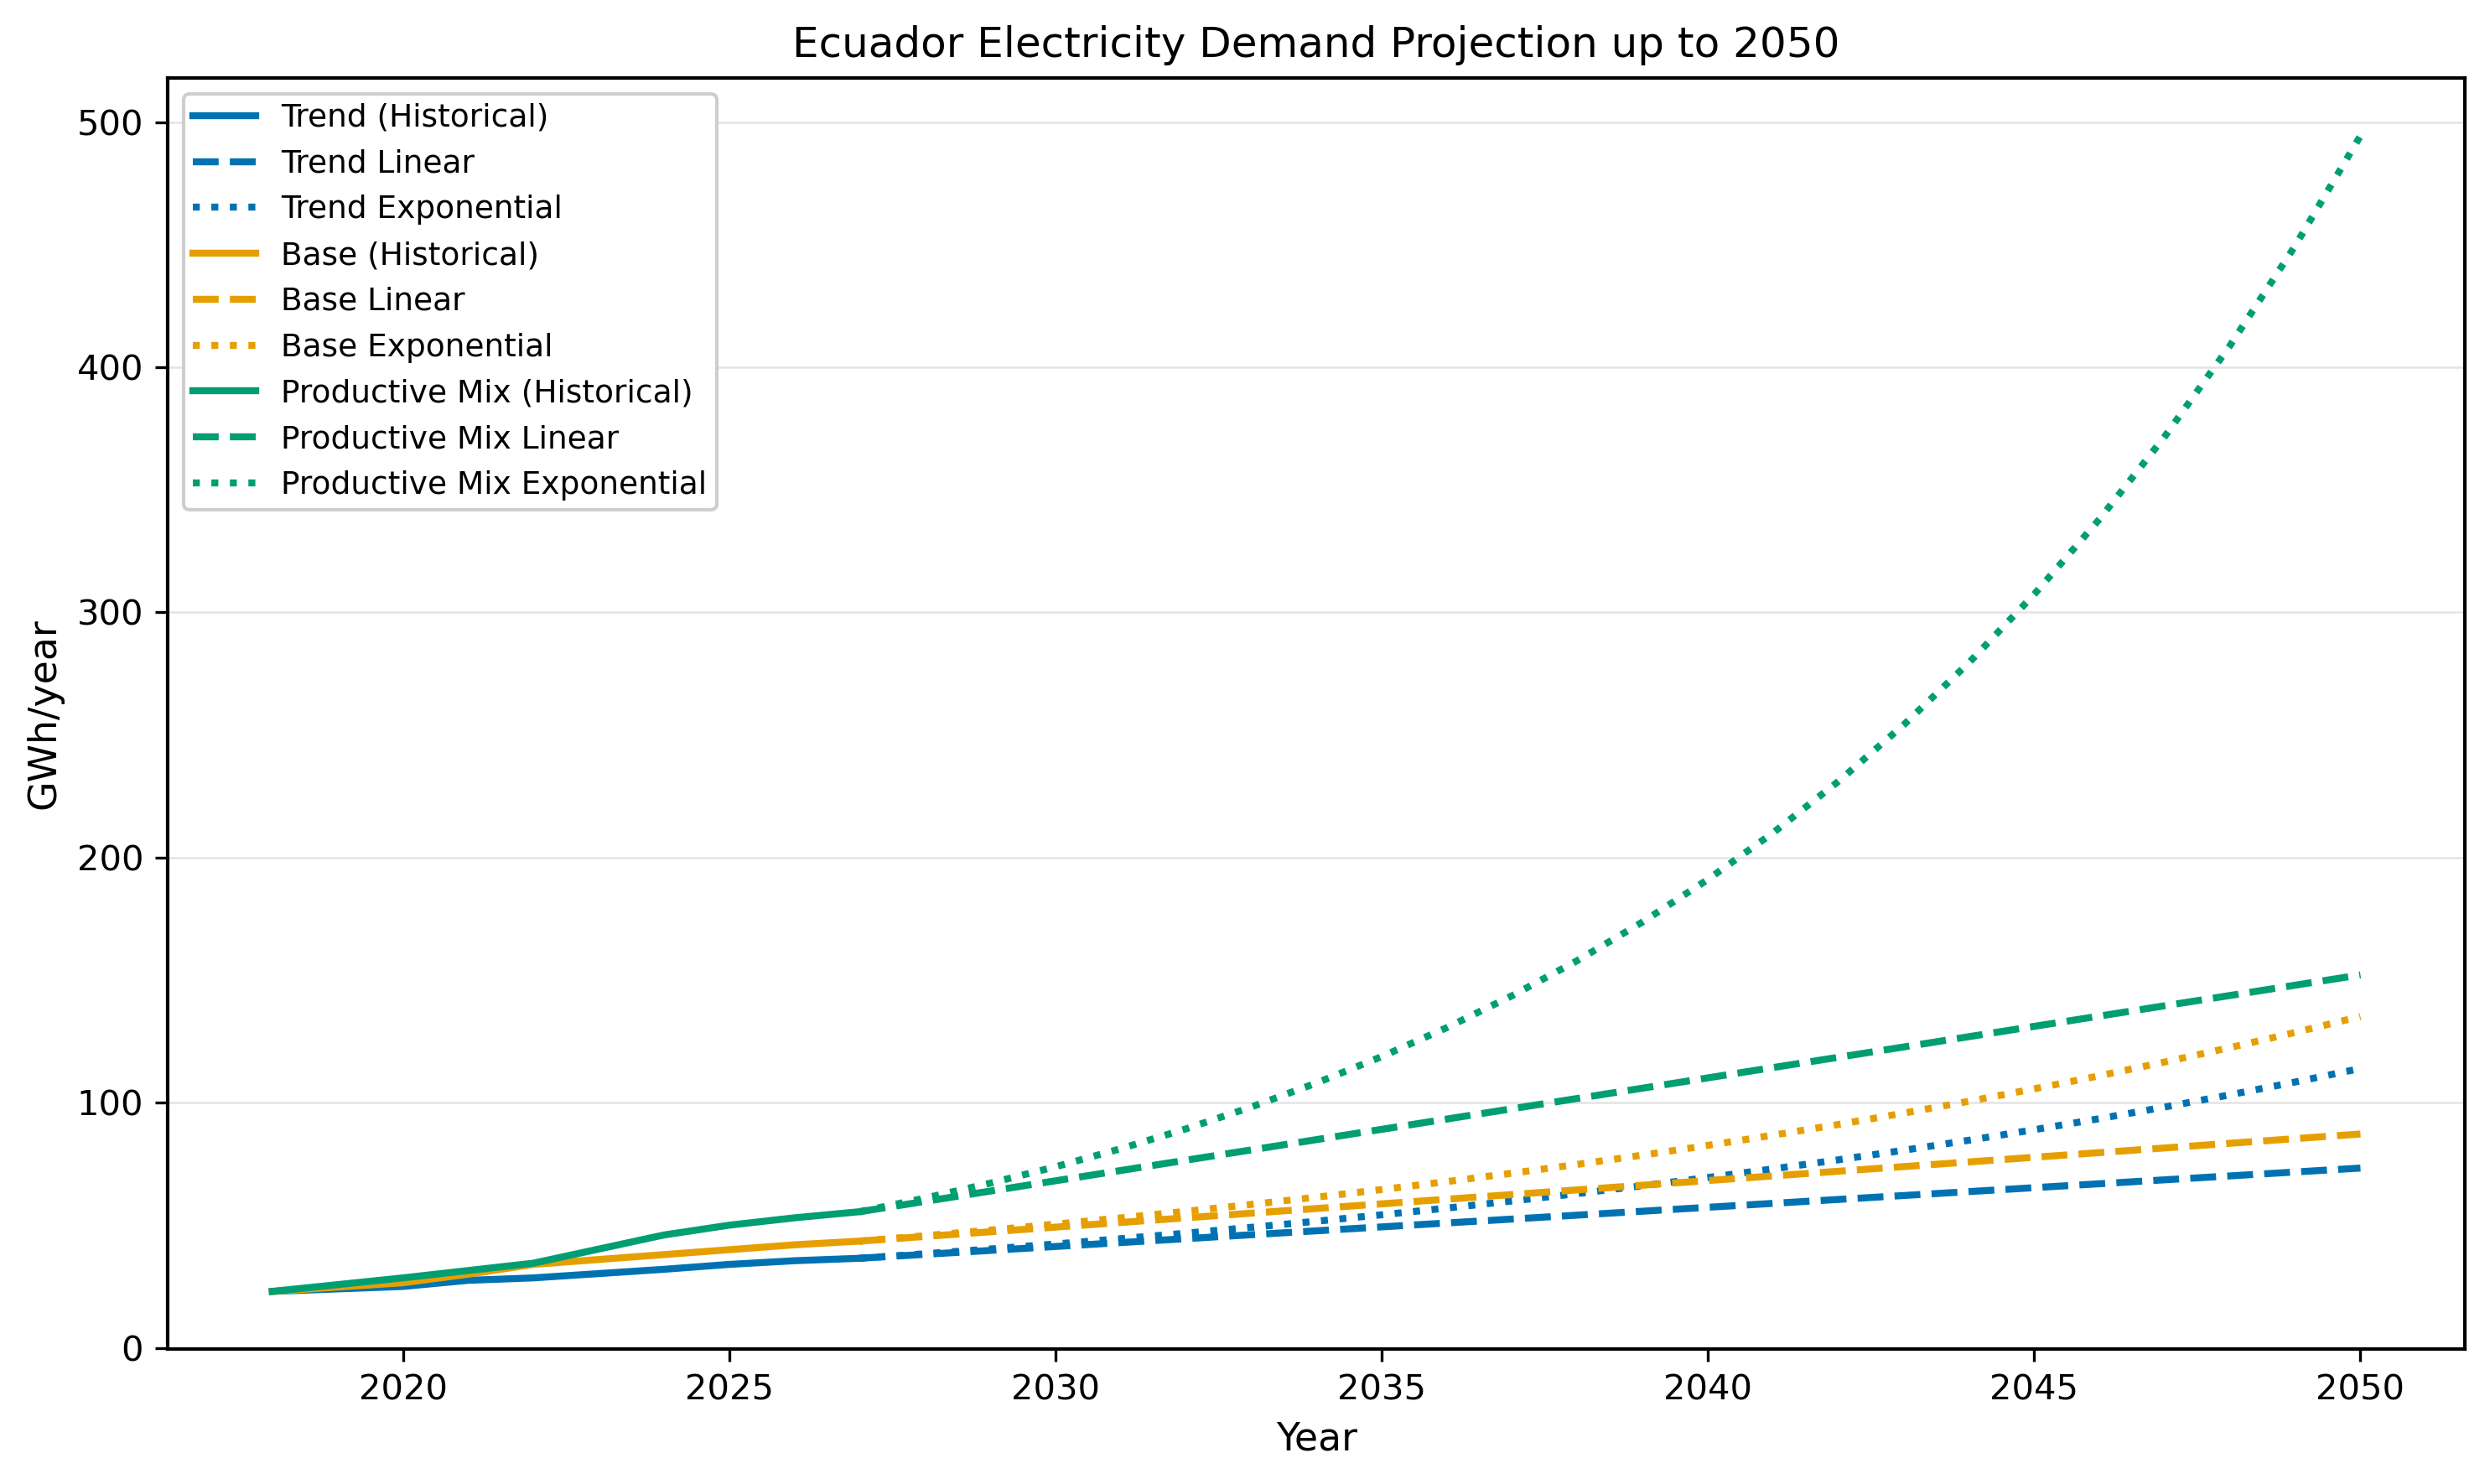

In [ ]:
# ---------- publication-ready style ----------
mpl.rcParams.update({
    "figure.figsize": (10, 6),      # single-column width for journals
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "font.family": "DejaVu Sans",      # or "Arial" if preferred by journal
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "axes.linewidth": 1.0,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "grid.linewidth": 0.6,
})

# Okabe–Ito colorblind-safe palette
okabe_ito = {
    "trend": "#0072B2",          # blue
    "base": "#E69F00",           # orange
    "productive_mix": "#009E73", # green
}

# Helper to capitalize words but keep spaces
def clean_label(base, suffix):
    base_clean = base.replace("_", " ").title()
    suffix_clean = suffix.title()
    return f"{base_clean} {suffix_clean}"

# Plot
plot_proj_years = list(range(hist_end_year, year_projection_end + 1))
plt.figure()

for base_scenario in scenarios:
    proj_df = results_df[base_scenario]
    c = okabe_ito[base_scenario]

    # Historical
    plt.plot(
        hist.index,
        hist[base_scenario],
        label=clean_label(base_scenario, "(Historical)"),
        color=c,
        linewidth=2.0,
    )

    # Linear projection
    plt.plot(
        plot_proj_years,
        proj_df["proj_linear_gwh"],
        "--",
        color=c,
        label=clean_label(base_scenario, "Linear"),
        linewidth=2.0,
    )

    # Exponential projection
    plt.plot(
        plot_proj_years,
        proj_df["proj_exponential_gwh"],
        ":",
        color=c,
        label=clean_label(base_scenario, "Exponential"),
        linewidth=2.0,
    )

# Final figure polish
plt.title(f"Ecuador Electricity Demand Projection up to {year_projection_end}")
plt.xlabel("Year")
plt.ylabel("GWh/year")
plt.grid(True, axis="y", alpha=0.35)
plt.legend(
    loc="upper left",
    frameon=True,
    framealpha=0.95,
    borderpad=0.3,
    handlelength=2.0,
)
plt.tight_layout()

# Save figure
plt.savefig(
    os.path.join(dirs["results/graphs"], "ecuador_demand_projection_2018_2050.png"),
    dpi=600,
)
plt.show()
